# Creating quantized implementation

Changelog:
+ 9.1: Rectified errors from mis-assigned variables and also from misspecifying whole network's `.qconfig` attribute

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np

In [3]:
import torch
import torch.nn as nn

## Work on creating proof of concept

Realized not too sure how to approach this. Do I go w/ a network that is designed to run on qints through and through? Or do I need to go through some quantization prep.

In [356]:
x = torch.tensor(np.linspace(-4, 4, 100)).float()

In [5]:
qx = torch.quantize_per_tensor(x, scale=0.025, zero_point=0, dtype=torch.qint8)

In [6]:
qx

tensor([-3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000,
        -3.2000, -3.2000, -3.2000, -3.1000, -3.0250, -2.9500, -2.8750, -2.8000,
        -2.7000, -2.6250, -2.5500, -2.4750, -2.3750, -2.3000, -2.2250, -2.1500,
        -2.0500, -1.9750, -1.9000, -1.8250, -1.7250, -1.6500, -1.5750, -1.5000,
        -1.4250, -1.3250, -1.2500, -1.1750, -1.1000, -1.0000, -0.9250, -0.8500,
        -0.7750, -0.6750, -0.6000, -0.5250, -0.4500, -0.3750, -0.2750, -0.2000,
        -0.1250, -0.0500,  0.0500,  0.1250,  0.2000,  0.2750,  0.3750,  0.4500,
         0.5250,  0.6000,  0.6750,  0.7750,  0.8500,  0.9250,  1.0000,  1.1000,
         1.1750,  1.2500,  1.3250,  1.4250,  1.5000,  1.5750,  1.6500,  1.7250,
         1.8250,  1.9000,  1.9750,  2.0500,  2.1500,  2.2250,  2.3000,  2.3750,
         2.4750,  2.5500,  2.6250,  2.7000,  2.8000,  2.8750,  2.9500,  3.0250,
         3.1000,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,
         3.1750,  3.1750,  3.1750,  3.17

In [7]:
lin = nn.Linear(in_features=100, out_features=10)

In [8]:
# lin(qx)
# 
# Normal layers cannot process quantized input

In [9]:
# This kills the kernel! 
# torch.backends.quantized.engine = "fbgemm"
# This doesn't!
torch.backends.quantized.engine = "qnnpack"

In [10]:
qlin = nn.quantized.Linear(in_features=100, out_features=10, dtype=torch.qint8)

In [11]:
qx_batch = torch.unsqueeze(qx, dim=0)

In [12]:
qx_batch

tensor([[-3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000,
         -3.2000, -3.2000, -3.2000, -3.1000, -3.0250, -2.9500, -2.8750, -2.8000,
         -2.7000, -2.6250, -2.5500, -2.4750, -2.3750, -2.3000, -2.2250, -2.1500,
         -2.0500, -1.9750, -1.9000, -1.8250, -1.7250, -1.6500, -1.5750, -1.5000,
         -1.4250, -1.3250, -1.2500, -1.1750, -1.1000, -1.0000, -0.9250, -0.8500,
         -0.7750, -0.6750, -0.6000, -0.5250, -0.4500, -0.3750, -0.2750, -0.2000,
         -0.1250, -0.0500,  0.0500,  0.1250,  0.2000,  0.2750,  0.3750,  0.4500,
          0.5250,  0.6000,  0.6750,  0.7750,  0.8500,  0.9250,  1.0000,  1.1000,
          1.1750,  1.2500,  1.3250,  1.4250,  1.5000,  1.5750,  1.6500,  1.7250,
          1.8250,  1.9000,  1.9750,  2.0500,  2.1500,  2.2250,  2.3000,  2.3750,
          2.4750,  2.5500,  2.6250,  2.7000,  2.8000,  2.8750,  2.9500,  3.0250,
          3.1000,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,
          3.1750,  3.1750,  

In [13]:
# qlin(qx_batch)

```
---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
<ipython-input-22-94699bf1c3c8> in <module>
----> 1 qlin(torch.unsqueeze(qx, dim=0))

~/miniconda3/envs/nn-gen-art/lib/python3.8/site-packages/torch/nn/modules/module.py in _call_impl(self, *input, **kwargs)
    725             result = self._slow_forward(*input, **kwargs)
    726         else:
--> 727             result = self.forward(*input, **kwargs)
    728         for hook in itertools.chain(
    729                 _global_forward_hooks.values(),

~/miniconda3/envs/nn-gen-art/lib/python3.8/site-packages/torch/nn/quantized/modules/linear.py in forward(self, x)
    164 
    165     def forward(self, x):
--> 166         return torch.ops.quantized.linear(
    167             x, self._packed_params._packed_params, self.scale, self.zero_point)
    168 

RuntimeError: expected scalar type QUInt8 but found QInt8
```

So ... quantized linear layer only works on quint8? Mm yeah apparently so from https://pytorch.org/docs/stable/torch.nn.quantized.html#torch.nn.quantized.functional.linear

Well, encode into quint8 I guess.

In [14]:
qx_uint = torch.quantize_per_tensor(x, scale=0.025, zero_point=128, dtype=torch.quint8)

In [15]:
qx_uint

tensor([-3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000, -3.2000,
        -3.2000, -3.2000, -3.2000, -3.1000, -3.0250, -2.9500, -2.8750, -2.8000,
        -2.7000, -2.6250, -2.5500, -2.4750, -2.3750, -2.3000, -2.2250, -2.1500,
        -2.0500, -1.9750, -1.9000, -1.8250, -1.7250, -1.6500, -1.5750, -1.5000,
        -1.4250, -1.3250, -1.2500, -1.1750, -1.1000, -1.0000, -0.9250, -0.8500,
        -0.7750, -0.6750, -0.6000, -0.5250, -0.4500, -0.3750, -0.2750, -0.2000,
        -0.1250, -0.0500,  0.0500,  0.1250,  0.2000,  0.2750,  0.3750,  0.4500,
         0.5250,  0.6000,  0.6750,  0.7750,  0.8500,  0.9250,  1.0000,  1.1000,
         1.1750,  1.2500,  1.3250,  1.4250,  1.5000,  1.5750,  1.6500,  1.7250,
         1.8250,  1.9000,  1.9750,  2.0500,  2.1500,  2.2250,  2.3000,  2.3750,
         2.4750,  2.5500,  2.6250,  2.7000,  2.8000,  2.8750,  2.9500,  3.0250,
         3.1000,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,  3.1750,
         3.1750,  3.1750,  3.1750,  3.17

In [16]:
torch.isclose(torch.dequantize(qx_uint), torch.dequantize(qx)).all()

tensor(True)

In [17]:
qx_batch = torch.unsqueeze(qx_uint, dim=0)

In [18]:
qlin(qx_batch)

tensor([[  0.,   0., 255.,   0., 255.,   0.,   0., 255.,   0., 255.]],
       size=(1, 10), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=1.0, zero_point=0)

Hmmm okay.

## Get a whole net of quantized linear layers to work

This net takes quint8 input and returns qint8 output. No conversion w/ floats required throughout the whole process.

In [58]:
class LinearNetAllQuant(nn.Module):
    def __init__(self, in_features: int = 10):
        super().__init__()
        self.fc1 = nn.quantized.Linear(in_features=in_features, out_features=10, dtype=torch.qint8)
        self.fc2 = nn.quantized.Linear(in_features=10, out_features=1, dtype=torch.qint8)
    
    def forward(self, x: torch.Tensor):
        y = self.fc1(x)
        y = self.fc2(y)
        return y

In [59]:
net = LinearNetAllQuant(4)

In [367]:
x = torch.normal(mean=0, std=1, size=(100, 4))

In [32]:
qx = torch.quantize_per_tensor(x, scale=0.025, zero_point=128, dtype=torch.quint8)

In [38]:
y = net(qx)

In [41]:
print(f"Input dtype is {qx.dtype}, output dtype is {y.dtype}")

Input dtype is torch.quint8, output dtype is torch.quint8


In [46]:
net.fc1.weight().dtype, net.fc1.bias().dtype, 

(torch.qint8, torch.float32)

Quantized Linear layers have float32 bias datatype!

In [53]:
y1 = net.fc1(qx)

In [55]:
y1.dtype

torch.quint8

Output of layer 1, which is fed into layer 2, is also quint8.

## Get a net of quantized linear layers to work

This net is the same as above, but takes a float input, and converts to a float output. Here is where we can try out two of the three quantizatoin methods in Pytorch: dynamic quantization and static quantization. Quant-aware training is not relevant since we're not training anything!

### Dynamic quantization

In [72]:
class LinearNetDynamicQuant(nn.Module):
    def __init__(self, in_features: int = 10):
        super().__init__()
        # This is a normal net! 
        self.fc1 = nn.Linear(in_features=in_features, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=1)
    
    def forward(self, x: torch.Tensor):
        y = self.fc1(x)
        y = self.fc2(y)
        return y

In [368]:
x = torch.normal(mean=0, std=1, size=(100, 4))

In [73]:
net = LinearNetDynamicQuant(4)

In [75]:
y = net(x)

In [76]:
x.dtype, y.dtype

(torch.float32, torch.float32)

This is a normal net.

In [77]:
qnet = torch.quantization.quantize_dynamic(net)

In [78]:
qnet

LinearNetDynamicQuant(
  (fc1): DynamicQuantizedLinear(in_features=4, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc2): DynamicQuantizedLinear(in_features=10, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

In [80]:
y = qnet(x)

In [81]:
x.dtype, y.dtype

(torch.float32, torch.float32)

This dynamically quantized net takes and returns floats.

In [86]:
qnet.fc1.weight().dtype, qnet.fc1.bias().dtype

(torch.qint8, torch.float32)

Expected.

In [84]:
qnet.fc1.weight()

tensor([[-0.3165, -0.3399,  0.1016, -0.4962],
        [-0.5001, -0.2266, -0.4532,  0.3165],
        [ 0.2657, -0.2383,  0.2266, -0.4923],
        [-0.1797, -0.3946, -0.1133,  0.4220],
        [ 0.0860,  0.2813, -0.4923,  0.2813],
        [ 0.3907, -0.0039,  0.2696,  0.2852],
        [-0.0703, -0.1211,  0.0313, -0.2579],
        [ 0.3907,  0.1680,  0.1680,  0.4728],
        [ 0.2188,  0.2032, -0.4611,  0.0742],
        [-0.2969, -0.4884,  0.4650,  0.0274]], size=(10, 4), dtype=torch.qint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.003907228820025921,
       zero_point=0)

In [85]:
qnet.fc1.bias()

tensor([ 0.0889, -0.1870,  0.3478, -0.0904, -0.4911, -0.1838, -0.1109, -0.1258,
         0.3060, -0.4888], grad_fn=<CopyBackwards>)

In [87]:
y1 = qnet.fc1(x)

In [89]:
y1.dtype

torch.float32

The output of the linear layer is still a float.

### Static quantization

In [90]:
class LinearNetStaticQuant(nn.Module):
    def __init__(self, in_features: int = 10):
        super().__init__()
        self.quant = torch.quantization.QuantStub()
        # Note that these are the normal Linear layers
        self.fc1 = nn.Linear(in_features=in_features, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=1)
        self.dequant = torch.quantization.DeQuantStub()
    
    def forward(self, x: torch.Tensor):
        y = self.quant(x)
        y = self.fc1(y)
        y = self.fc2(y)
        y = self.dequant(y)
        return y

In [369]:
x = torch.normal(mean=0, std=1, size=(100, 4))

In [91]:
net = LinearNetStaticQuant(4)

In [114]:
net.qconfig = torch.quantization.get_default_qconfig('qnnpack')

In [115]:
# Quantized layers wouldn't pass this function!
prepped_net = torch.quantization.prepare(net)

In [116]:
prepped_net

LinearNetStaticQuant(
  (quant): QuantStub(
    (activation_post_process): HistogramObserver()
  )
  (fc1): Linear(
    in_features=4, out_features=10, bias=True
    (activation_post_process): HistogramObserver()
  )
  (fc2): Linear(
    in_features=10, out_features=1, bias=True
    (activation_post_process): HistogramObserver()
  )
  (dequant): DeQuantStub()
)

In [120]:
# Calibration of prepped net
y = prepped_net(x)

In [122]:
qnet = torch.quantization.convert(prepped_net)

In [123]:
qnet

LinearNetStaticQuant(
  (quant): Quantize(scale=tensor([0.0238]), zero_point=tensor([148]), dtype=torch.quint8)
  (fc1): QuantizedLinear(in_features=4, out_features=10, scale=0.01829962432384491, zero_point=148, qscheme=torch.per_tensor_affine)
  (fc2): QuantizedLinear(in_features=10, out_features=1, scale=0.002619570353999734, zero_point=255, qscheme=torch.per_tensor_affine)
  (dequant): DeQuantize()
)

In [127]:
y = qnet(x)

In [128]:
x.dtype, y.dtype

(torch.float32, torch.float32)

In [132]:
y1 = qnet.fc1(qx)

In [133]:
y1.dtype

torch.quint8

So the benefit of using static quantization is that the int conversions only occur at the quant and dequant stubs. Dynamic quantization will do this packing and unpacking at every layer! 

For my use case, static quantization is better over dynamic quantization. Doing manual quantization is pretty much the same as static quantization except the quantization itself is calibrated to the data. Starting to get the impression that end users are not meant to implement the quantized layers by hand, but via the quantization steps in Pytorch docs.

## Get a net with activations to work through quantization

### Dynamic quant for nets with activations

In [364]:
class LinearNetDynamicQuant(nn.Module):
    def __init__(self, in_features: int = 10):
        super().__init__()
        # This is a normal net! 
        self.fc1 = nn.Linear(in_features=in_features, out_features=10)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(in_features=10, out_features=1)
        self.tanh2 = nn.Tanh()
    
    def forward(self, x: torch.Tensor):
        y = self.fc1(x)
        y = self.tanh1(y)
        y = self.fc2(y)
        y = self.tanh2(y)
        return y

In [370]:
x = torch.normal(mean=0, std=1, size=(100, 4))

In [371]:
net = LinearNetDynamicQuant(4)

In [372]:
y = net(x)

In [373]:
x.dtype, y.dtype

(torch.float32, torch.float32)

In [374]:
qnet = torch.quantization.quantize_dynamic(net)

In [375]:
qnet

LinearNetDynamicQuant(
  (fc1): DynamicQuantizedLinear(in_features=4, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (tanh1): Tanh()
  (fc2): DynamicQuantizedLinear(in_features=10, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (tanh2): Tanh()
)

In [142]:
y = qnet(x)

In [143]:
x.dtype, y.dtype

(torch.float32, torch.float32)

In [145]:
qnet.fc1.weight().dtype, qnet.fc1.bias().dtype

(torch.qint8, torch.float32)

In [148]:
qnet.tanh1

Tanh()

Expected.

In [149]:
y1 = qnet.fc1(x)

In [150]:
y1.dtype

torch.float32

In [151]:
qnet.tanh1

Tanh()

In [155]:
qnet.tanh1(x).dtype

torch.float32

No change to activations in dynamic quantization.

### Static quantization

In this net, we placed one tanh between quant stubs, and one tanh out of quant stubs.

In [195]:
class LinearNetStaticQuant(nn.Module):
    def __init__(self, in_features: int = 10):
        super().__init__()
        self.quant = torch.quantization.QuantStub()
        # Note that these are the normal Linear layers
        self.fc1 = nn.Linear(in_features=in_features, out_features=10)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(in_features=10, out_features=1)
        self.tanh2 = nn.Tanh()
        self.dequant = torch.quantization.DeQuantStub()
    
    def forward(self, x: torch.Tensor):
        y = self.quant(x)
        y = self.fc1(y)
        y = self.tanh1(y)
        y = self.fc2(y)
        y = self.dequant(y)
        y = self.tanh2(y)
        return y

In [376]:
x = torch.normal(mean=0, std=1, size=(100, 4))

In [196]:
net = LinearNetStaticQuant(4)

In [197]:
net.qconfig = torch.quantization.get_default_qconfig('qnnpack')

In [198]:
# Quantized layers wouldn't pass this function!
prepped_net = torch.quantization.prepare(net)

In [199]:
prepped_net

LinearNetStaticQuant(
  (quant): QuantStub(
    (activation_post_process): HistogramObserver()
  )
  (fc1): Linear(
    in_features=4, out_features=10, bias=True
    (activation_post_process): HistogramObserver()
  )
  (tanh1): Tanh()
  (fc2): Linear(
    in_features=10, out_features=1, bias=True
    (activation_post_process): HistogramObserver()
  )
  (tanh2): Tanh()
  (dequant): DeQuantStub()
)

In [200]:
# Calibration of prepped net
y = prepped_net(x)

In [201]:
qnet = torch.quantization.convert(prepped_net)

In [202]:
qnet

LinearNetStaticQuant(
  (quant): Quantize(scale=tensor([0.0238]), zero_point=tensor([148]), dtype=torch.quint8)
  (fc1): QuantizedLinear(in_features=4, out_features=10, scale=0.016543732956051826, zero_point=135, qscheme=torch.per_tensor_affine)
  (tanh1): Tanh()
  (fc2): QuantizedLinear(in_features=10, out_features=1, scale=0.007816036231815815, zero_point=113, qscheme=torch.per_tensor_affine)
  (tanh2): Tanh()
  (dequant): DeQuantize()
)

In [203]:
y = qnet(x)

In [207]:
y[:10, 0]

tensor([ 0.5272,  0.7001,  0.5042,  0.6712, -0.1854,  0.1167,  0.0156, -0.1703,
         0.2303,  0.5655])

In [166]:
x.dtype, y.dtype

(torch.float32, torch.float32)

In [167]:
y1 = qnet.fc1(qx)

In [168]:
y1.dtype

torch.quint8

In [170]:
y2 = qnet.tanh1(y1)

In [172]:
y1.dtype, y2.dtype

(torch.quint8, torch.quint8)

Surprisingly, tanh can take quantized input and output quantized output?

In [177]:
qnet.tanh2(x).dtype, qnet.tanh2(qx).dtype

(torch.float32, torch.quint8)

Didn't know tanh is quantization-agnostic in torch. More on this later.

How about no dequantstub?

In [357]:
class LinearNetStaticQuantNoDeQuant(nn.Module):
    def __init__(self, in_features: int = 10):
        super().__init__()
        self.quant = torch.quantization.QuantStub()
        # Note that these are the normal Linear layers
        self.fc1 = nn.Linear(in_features=in_features, out_features=10)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(in_features=10, out_features=1)
        self.tanh2 = nn.Tanh()
        # self.dequant = torch.quantization.DeQuantStub()
    
    def forward(self, x: torch.Tensor):
        y = self.quant(x)
        y = self.fc1(y)
        y = self.tanh1(y)
        y = self.fc2(y)
        # y = self.dequant(y)
        y = self.tanh2(y)
        return y

In [377]:
x = torch.normal(mean=0, std=1, size=(100, 4))

In [378]:
net = LinearNetStaticQuantNoDeQuant(4)

In [379]:
net.qconfig = torch.quantization.get_default_qconfig('qnnpack')

In [380]:
# Quantized layers wouldn't pass this function!
prepped_net = torch.quantization.prepare(net)

In [381]:
prepped_net

LinearNetStaticQuantNoDeQuant(
  (quant): QuantStub(
    (activation_post_process): HistogramObserver()
  )
  (fc1): Linear(
    in_features=4, out_features=10, bias=True
    (activation_post_process): HistogramObserver()
  )
  (tanh1): Tanh()
  (fc2): Linear(
    in_features=10, out_features=1, bias=True
    (activation_post_process): HistogramObserver()
  )
  (tanh2): Tanh()
)

In [382]:
# Calibration of prepped net
y = prepped_net(x)

In [383]:
qnet = torch.quantization.convert(prepped_net)

In [384]:
qnet

LinearNetStaticQuantNoDeQuant(
  (quant): Quantize(scale=tensor([0.0237]), zero_point=tensor([121]), dtype=torch.quint8)
  (fc1): QuantizedLinear(in_features=4, out_features=10, scale=0.016230713576078415, zero_point=125, qscheme=torch.per_tensor_affine)
  (tanh1): Tanh()
  (fc2): QuantizedLinear(in_features=10, out_features=1, scale=0.0028043240308761597, zero_point=122, qscheme=torch.per_tensor_affine)
  (tanh2): Tanh()
)

In [385]:
y = qnet(x)

In [386]:
y[:10, 0]

tensor([ 0.0859,  0.1250,  0.0078,  0.1797, -0.0391,  0.1797, -0.1406,  0.0234,
         0.0312, -0.3281], size=(10,), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.0078125,
       zero_point=128)

In [387]:
x.dtype, y.dtype

(torch.float32, torch.quint8)

Possible to freely place quantstubs and dequantstubs eh.

How about moving one linear layer out of the dequant stub?

In [388]:
class LinearNetStaticHalfQuant(nn.Module):
    def __init__(self, in_features: int = 10):
        super().__init__()
        self.quant = torch.quantization.QuantStub()
        # Note that these are the normal Linear layers
        self.fc1 = nn.Linear(in_features=in_features, out_features=10)
        self.tanh1 = nn.Tanh()
        self.dequant = torch.quantization.DeQuantStub()
        self.fc2 = nn.Linear(in_features=10, out_features=1)
        self.tanh2 = nn.Tanh()
    
    def forward(self, x: torch.Tensor):
        y = self.quant(x)
        y = self.fc1(y)
        y = self.tanh1(y)
        y = self.dequant(y)
        y = self.fc2(y)
        y = self.tanh2(y)
        return y

In [389]:
x = torch.normal(mean=0, std=1, size=(100, 4))

In [402]:
net = LinearNetStaticHalfQuant(4)

In [403]:
# Being careful here!
net.quant.qconfig = torch.quantization.get_default_qconfig('qnnpack')
net.fc1.qconfig = torch.quantization.get_default_qconfig('qnnpack')
net.tanh1.qconfig = torch.quantization.get_default_qconfig('qnnpack')

In [404]:
# Quantized layers wouldn't pass this function!
prepped_net = torch.quantization.prepare(net)

In [405]:
prepped_net

LinearNetStaticHalfQuant(
  (quant): QuantStub(
    (activation_post_process): HistogramObserver()
  )
  (fc1): Linear(
    in_features=4, out_features=10, bias=True
    (activation_post_process): HistogramObserver()
  )
  (tanh1): Tanh()
  (dequant): DeQuantStub()
  (fc2): Linear(in_features=10, out_features=1, bias=True)
  (tanh2): Tanh()
)

In [406]:
# Calibration of prepped net
y = prepped_net(x)

In [407]:
qnet = torch.quantization.convert(prepped_net)

In [408]:
qnet

LinearNetStaticHalfQuant(
  (quant): Quantize(scale=tensor([0.0188]), zero_point=tensor([130]), dtype=torch.quint8)
  (fc1): QuantizedLinear(in_features=4, out_features=10, scale=0.0183976162225008, zero_point=118, qscheme=torch.per_tensor_affine)
  (tanh1): Tanh()
  (dequant): DeQuantize()
  (fc2): Linear(in_features=10, out_features=1, bias=True)
  (tanh2): Tanh()
)

Linear layer out of quant/dequant is not quantized.

In [411]:
y = qnet(x)

In [412]:
y[:10, 0]

tensor([-0.4374,  0.3733, -0.2696, -0.1080, -0.3791,  0.1808,  0.0235, -0.1427,
        -0.4926, -0.5685], grad_fn=<SelectBackward>)

As long as the `qconfig` property is specified properly, it is possible to mix and match qint / float computation!

## Quantized net with manually specified quantization mixed with activations

In [188]:
class LinearNetAllQuantWithActivation(nn.Module):
    def __init__(self, in_features: int = 10):
        super().__init__()
        self.fc1 = nn.quantized.Linear(in_features=in_features, out_features=10)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.quantized.Linear(in_features=10, out_features=1)
        self.tanh2 = nn.Tanh()
    
    def forward(self, x: torch.Tensor):
        y = self.fc1(x)
        y = self.tanh1(y)
        y = self.fc2(y)
        y = self.tanh2(y)
        return y

In [209]:
qnet = LinearNetAllQuantWithActivation(4)

In [210]:
qy = qnet(qx)

In [211]:
y = torch.dequantize(qy)

In [194]:
# y

qy output was all zeros, which is terrible! Realized that quantization parameters for individual quantized Linear layers cannot be set during layer init.

In [215]:
qnet.fc1.scale, qnet.fc1.zero_point

(1.0, 0)

The quantization parameters are accessible but need to be set manually. Therefore, this needs to be something like this:

In [216]:
class LinearNetAllQuantWithActivation(nn.Module):
    def __init__(self, in_features: int = 10):
        super().__init__()
        self.fc1 = nn.quantized.Linear(in_features=in_features, out_features=10)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.quantized.Linear(in_features=10, out_features=1)
        self.tanh2 = nn.Tanh()
        
        self.fc1.zero_point = 128
        self.fc2.scale = 0.025
        self.fc1.zero_point = 128
        self.fc2.scale = 0.025
    
    def forward(self, x: torch.Tensor):
        y = self.fc1(x)
        y = self.tanh1(y)
        y = self.fc2(y)
        y = self.tanh2(y)
        return y

In [217]:
qnet = LinearNetAllQuantWithActivation(4)

In [232]:
# qnet.tanh1(qnet.fc1(qx))

Noticed that the Tanh layers always use quint8 data type, 128 as zero point, and 0.0078125 as scale.

In [230]:
torch.quantize_per_tensor(torch.tensor(np.linspace(-1, 1, 100)).float(), zero_point=128, scale=0.0078125, dtype=torch.quint8)

tensor([-1.0000, -0.9766, -0.9609, -0.9375, -0.9219, -0.8984, -0.8750, -0.8594,
        -0.8359, -0.8203, -0.7969, -0.7812, -0.7578, -0.7344, -0.7188, -0.6953,
        -0.6797, -0.6562, -0.6328, -0.6172, -0.5938, -0.5781, -0.5547, -0.5391,
        -0.5156, -0.4922, -0.4766, -0.4531, -0.4375, -0.4141, -0.3906, -0.3750,
        -0.3516, -0.3359, -0.3125, -0.2891, -0.2734, -0.2500, -0.2344, -0.2109,
        -0.1953, -0.1719, -0.1484, -0.1328, -0.1094, -0.0938, -0.0703, -0.0469,
        -0.0312, -0.0078,  0.0078,  0.0312,  0.0469,  0.0703,  0.0938,  0.1094,
         0.1328,  0.1484,  0.1719,  0.1953,  0.2109,  0.2344,  0.2500,  0.2734,
         0.2891,  0.3125,  0.3359,  0.3516,  0.3750,  0.3906,  0.4141,  0.4375,
         0.4531,  0.4766,  0.4922,  0.5156,  0.5391,  0.5547,  0.5781,  0.5938,
         0.6172,  0.6328,  0.6562,  0.6797,  0.6953,  0.7188,  0.7344,  0.7578,
         0.7812,  0.7969,  0.8203,  0.8359,  0.8594,  0.8750,  0.8984,  0.9219,
         0.9375,  0.9609,  0.9766,  0.99

In [229]:
128 * 0.0078125

1.0

Which actually splits the 128 steps above and below the zero point to neatly reach +/- 1.0 in 0.0078125 increments!

Going to leave further work on quantizing the non-linear activations to the 7.0 notebook.

## Work on net generator

Choosing to go with static quantization since it saves time from fiddling with individual layer quantization parameters.

In [267]:
from art import Net, generate_one_art, create_input

In [429]:
class QuantizedNet(Net):
    def init_arch(
        self,
        num_hidden_layers,
        num_neurons,
        latent_len,
        include_bias,
        include_dist_to_origin,
        rgb,
    ) -> nn.Sequential:
        
        layers = OrderedDict()
        
        # Input layer
        if include_dist_to_origin:
            layers.update(
                {
                    # 3 base inputs per pixel: x, y, distance to origin
                    # on top of the latent vector
                    "fc0": nn.Linear(3 + latent_len, num_neurons, bias=include_bias),
                    "tanh0": nn.Tanh(),
                }
            )

        else:
            layers.update(
                {
                    # 2 base inputs per pixel: x, y
                    # on top of the latent vector
                    "fc0": nn.Linear(2 + latent_len, num_neurons, bias=include_bias),
                    "tanh0": nn.Tanh(),
                }
            )

        # Insert quantization
        # Don't know what oddities will go into the top layer so keeping it out of quantization
        # Edit: must start with this
        # Edit: Nope was mistaken, labelled entire network to have qconfig
        layers.update({"quant": torch.quantization.QuantStub()})
            
        # Hidden layers
        for i in range(num_hidden_layers):
            layers.update(
                {
                    "fc" + str(i + 1): nn.Linear(num_neurons, num_neurons, bias=False),
                    "tanh" + str(i + 1): nn.Tanh(),
                }
            )
            
        # End quantization
        # Not too sure if the output layer should sit in this
        # Edit: must end with this
        # Edit: Nope was mistaken, labelled entire network to have qconfig
        layers.update({"dequant": torch.quantization.DeQuantStub()})
            
        # Output layer
        if rgb:
            layers.update(
                {
                    "fc" + str(i + 1 + 1): nn.Linear(num_neurons, 3, bias=False),
                    "sigmoid": nn.Sigmoid(),
                }
            )
        else:
            layers.update(
                {
                    "fc" + str(i + 1 + 1): nn.Linear(num_neurons, 1, bias=False),
                    "sigmoid": nn.Sigmoid(),
                }
            )

            
        # Assign layers to self.layers
        return nn.Sequential(layers)
    
    def init_weights(self):
        def layer_init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=1)
        self.apply(layer_init_weights)

In [430]:
net = QuantizedNet(num_hidden_layers=2, num_neurons=64)

In [431]:
net

QuantizedNet(
  (layers): Sequential(
    (fc0): Linear(in_features=6, out_features=64, bias=True)
    (tanh0): Tanh()
    (quant): QuantStub()
    (fc1): Linear(in_features=64, out_features=64, bias=False)
    (tanh1): Tanh()
    (fc2): Linear(in_features=64, out_features=64, bias=False)
    (tanh2): Tanh()
    (dequant): DeQuantStub()
    (fc3): Linear(in_features=64, out_features=3, bias=False)
    (sigmoid): Sigmoid()
  )
)

In [432]:
net.layers.quant.qconfig = torch.quantization.get_default_qconfig('qnnpack')
net.layers.fc1.qconfig = torch.quantization.get_default_qconfig('qnnpack')
net.layers.tanh1.qconfig = torch.quantization.get_default_qconfig('qnnpack')
net.layers.fc2.qconfig = torch.quantization.get_default_qconfig('qnnpack')
net.layers.tanh2.qconfig = torch.quantization.get_default_qconfig('qnnpack')
net.layers.dequant.qconfig = torch.quantization.get_default_qconfig('qnnpack')

### Using the net before quantization

In [433]:
out = generate_one_art(net, torch.normal(mean=0, std=1, size=(3,)))

In [434]:
%%timeit
out = generate_one_art(net, torch.normal(mean=0, std=1, size=(3,)))

105 ms ± 7.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


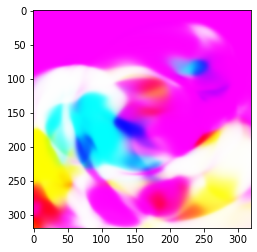

In [435]:
plt.imshow(out)

Output looks valid.

In [436]:
prepped_net = torch.quantization.prepare(net)

In [437]:
prepped_net

QuantizedNet(
  (layers): Sequential(
    (fc0): Linear(in_features=6, out_features=64, bias=True)
    (tanh0): Tanh()
    (quant): QuantStub(
      (activation_post_process): HistogramObserver()
    )
    (fc1): Linear(
      in_features=64, out_features=64, bias=False
      (activation_post_process): HistogramObserver()
    )
    (tanh1): Tanh()
    (fc2): Linear(
      in_features=64, out_features=64, bias=False
      (activation_post_process): HistogramObserver()
    )
    (tanh2): Tanh()
    (dequant): DeQuantStub()
    (fc3): Linear(in_features=64, out_features=3, bias=False)
    (sigmoid): Sigmoid()
  )
)

In [438]:
# Calibration of prepped net
# y = prepped_net(x)
out = generate_one_art(prepped_net, torch.normal(mean=0, std=1, size=(3,)))

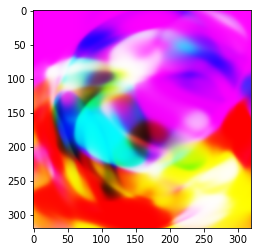

In [439]:
plt.imshow(out)

In [440]:
qnet = torch.quantization.convert(prepped_net)

Trying it out:

In [441]:
out = generate_one_art(qnet, torch.normal(mean=0, std=1, size=(3,)))

```
Same error. Appears that once quantized, the net is not supposed to contain any operations involving float inputs, even like the torch concat that occurs before forwarding info through the layers! Moved the quantstub to the first layer, still same error. Moved the dequantstub to the last layer, fixed. Appears that the static quantization process does not allow flexibility in mixing ints / floats.
```

Edit: Nope, just accidentally set qconfig for the entire net.

In [442]:
out = generate_one_art(qnet, torch.normal(mean=0, std=1, size=(3,)))

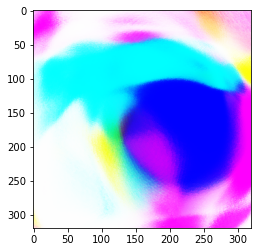

In [443]:
plt.imshow(out)

In [444]:
%%timeit
out = generate_one_art(qnet, torch.normal(mean=0, std=1, size=(3,)))

148 ms ± 6.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Well, this is slower! 

I suppose I have achieved the purpose of this notebook which is to figure out doing this as quantized NNs. Doing performance comparisons need to be separated into another notebook.